# Introduction to Generative AI

## Imports and constants

In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from IPython.display import display
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Generation vs Classification task

### Intro and data

In [3]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

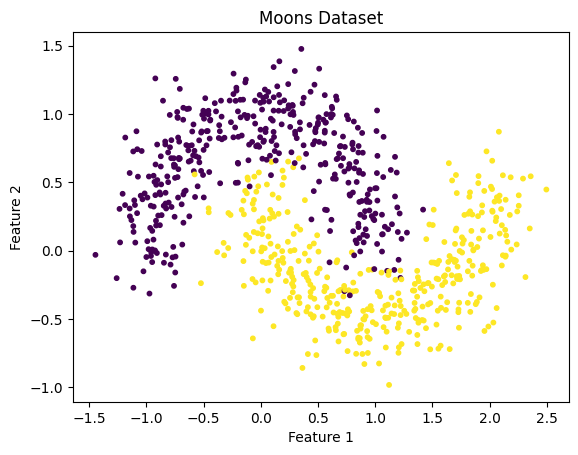

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Moons Dataset')
plt.show()

**Classification task**: $P(y|x)$

**Generation task**: $P(x|y)$

### Simple classification network

In [5]:
class MoonsClassifier(nn.Module):
    def __init__(self):
        super(MoonsClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
clf = MoonsClassifier()
clf.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=0.01)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = clf(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = clf(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor)
        outputs = (outputs > 0.5).float()
        accuracy = ((outputs == y_test_tensor).sum().item()) / y_test_tensor.size(0)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1], Loss: 0.6890, Test Loss: 0.6820, Accuracy: 0.5000
Epoch [2], Loss: 0.6802, Test Loss: 0.6742, Accuracy: 0.5000
Epoch [3], Loss: 0.6713, Test Loss: 0.6663, Accuracy: 0.5000
Epoch [4], Loss: 0.6622, Test Loss: 0.6578, Accuracy: 0.5000
Epoch [5], Loss: 0.6526, Test Loss: 0.6487, Accuracy: 0.5000
Epoch [6], Loss: 0.6423, Test Loss: 0.6389, Accuracy: 0.5000
Epoch [7], Loss: 0.6311, Test Loss: 0.6282, Accuracy: 0.5000
Epoch [8], Loss: 0.6193, Test Loss: 0.6167, Accuracy: 0.5650
Epoch [9], Loss: 0.6066, Test Loss: 0.6046, Accuracy: 0.7150
Epoch [10], Loss: 0.5933, Test Loss: 0.5918, Accuracy: 0.7550
Epoch [11], Loss: 0.5794, Test Loss: 0.5784, Accuracy: 0.7450
Epoch [12], Loss: 0.5648, Test Loss: 0.5643, Accuracy: 0.7600
Epoch [13], Loss: 0.5498, Test Loss: 0.5497, Accuracy: 0.7550
Epoch [14], Loss: 0.5343, Test Loss: 0.5345, Accuracy: 0.7600
Epoch [15], Loss: 0.5185, Test Loss: 0.5190, Accuracy: 0.7500
Epoch [16], Loss: 0.5025, Test Loss: 0.5032, Accuracy: 0.7750
Epoch [17], Loss:

Visualize the decision boundary:

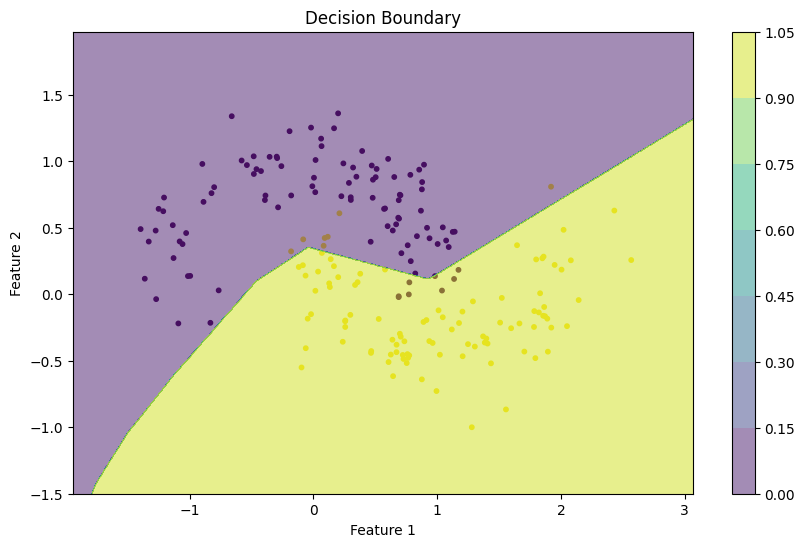

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap='viridis')
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                     np.arange(y_min, y_max, 0.005))
with torch.no_grad():
    Z = clf(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.squeeze().numpy()
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

### Simple generative network

Let's reverse the network:

In [8]:
class MoonsGenerator1(nn.Module):
    def __init__(self):
        super(MoonsGenerator1, self).__init__()
        self.fc1 = nn.Linear(1, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
gen = MoonsGenerator1()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = gen(y_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = gen(y_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.6291, Test Loss: 0.5851
Epoch [2], Loss: 0.5961, Test Loss: 0.5535
Epoch [3], Loss: 0.5665, Test Loss: 0.5256
Epoch [4], Loss: 0.5405, Test Loss: 0.5018
Epoch [5], Loss: 0.5186, Test Loss: 0.4827
Epoch [6], Loss: 0.5013, Test Loss: 0.4681
Epoch [7], Loss: 0.4884, Test Loss: 0.4578
Epoch [8], Loss: 0.4797, Test Loss: 0.4513
Epoch [9], Loss: 0.4744, Test Loss: 0.4469
Epoch [10], Loss: 0.4709, Test Loss: 0.4428
Epoch [11], Loss: 0.4673, Test Loss: 0.4375
Epoch [12], Loss: 0.4621, Test Loss: 0.4304
Epoch [13], Loss: 0.4546, Test Loss: 0.4217
Epoch [14], Loss: 0.4452, Test Loss: 0.4126
Epoch [15], Loss: 0.4350, Test Loss: 0.4027
Epoch [16], Loss: 0.4237, Test Loss: 0.3930
Epoch [17], Loss: 0.4124, Test Loss: 0.3837
Epoch [18], Loss: 0.4014, Test Loss: 0.3754
Epoch [19], Loss: 0.3912, Test Loss: 0.3680
Epoch [20], Loss: 0.3817, Test Loss: 0.3617
Epoch [21], Loss: 0.3735, Test Loss: 0.3564
Epoch [22], Loss: 0.3661, Test Loss: 0.3520
Epoch [23], Loss: 0.3596, Test Loss: 0.34

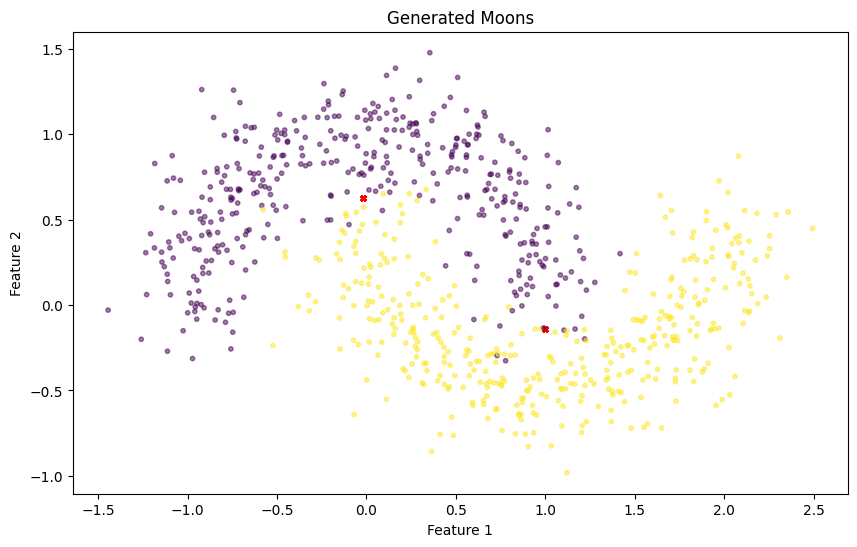

In [10]:
upper_moon_gen = gen(torch.FloatTensor([[1.0]] * 100))
lower_moon_gen = gen(torch.FloatTensor([[0.0]] * 100))
X_gen = torch.cat((upper_moon_gen, lower_moon_gen), dim=0).detach().numpy()
y_gen = np.concatenate((np.ones(100), np.zeros(100)), axis=0)
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Determenistic $\rightarrow$ single result

In [11]:
class MoonsGenerator2(nn.Module):
    def __init__(self):
        super(MoonsGenerator2, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
gen = MoonsGenerator2()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    train_noise = torch.randn(X_train_tensor.size(0), 1)
    y_train_tensor_ = torch.cat((y_train_tensor, train_noise), dim=1)
    outputs = gen(y_train_tensor_)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        test_noise = torch.randn(X_test_tensor.size(0), 1)
        y_test_tensor_ = torch.cat((y_test_tensor, test_noise), dim=1)
        outputs = gen(y_test_tensor_)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.7782, Test Loss: 0.7379
Epoch [2], Loss: 0.7392, Test Loss: 0.6977
Epoch [3], Loss: 0.7036, Test Loss: 0.6671
Epoch [4], Loss: 0.6728, Test Loss: 0.6362
Epoch [5], Loss: 0.6451, Test Loss: 0.6102
Epoch [6], Loss: 0.6213, Test Loss: 0.5810
Epoch [7], Loss: 0.5990, Test Loss: 0.5661
Epoch [8], Loss: 0.5783, Test Loss: 0.5461
Epoch [9], Loss: 0.5610, Test Loss: 0.5299
Epoch [10], Loss: 0.5485, Test Loss: 0.5139
Epoch [11], Loss: 0.5376, Test Loss: 0.5029
Epoch [12], Loss: 0.5258, Test Loss: 0.4991
Epoch [13], Loss: 0.5151, Test Loss: 0.4867
Epoch [14], Loss: 0.5107, Test Loss: 0.4739
Epoch [15], Loss: 0.5032, Test Loss: 0.4688
Epoch [16], Loss: 0.4986, Test Loss: 0.4647
Epoch [17], Loss: 0.4864, Test Loss: 0.4581
Epoch [18], Loss: 0.4782, Test Loss: 0.4494
Epoch [19], Loss: 0.4698, Test Loss: 0.4332
Epoch [20], Loss: 0.4582, Test Loss: 0.4272
Epoch [21], Loss: 0.4479, Test Loss: 0.4154
Epoch [22], Loss: 0.4345, Test Loss: 0.4049
Epoch [23], Loss: 0.4239, Test Loss: 0.39

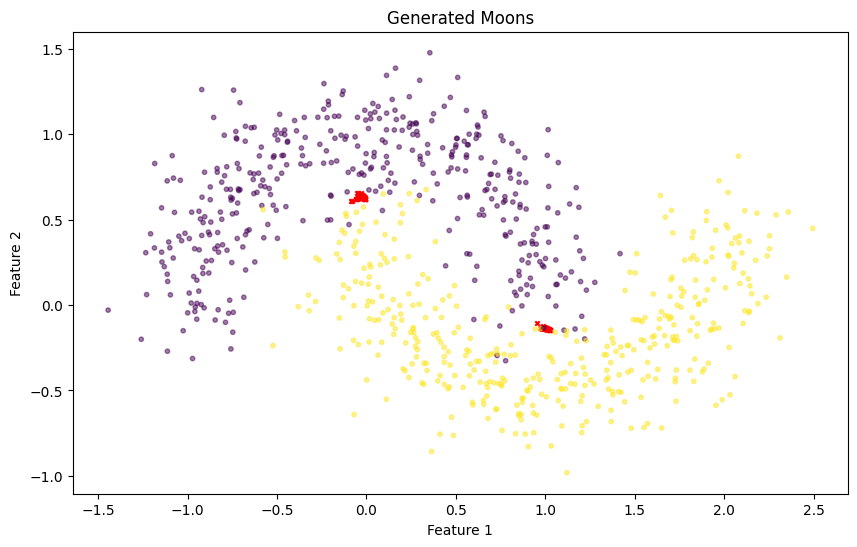

In [13]:
gen_input = torch.cat((torch.cat((torch.FloatTensor([[1.0]] * 100), torch.FloatTensor([[0.0]] * 100)), dim=0), torch.randn(200, 1)), dim=1)
with torch.no_grad():
    X_gen = gen(gen_input)
X_gen = X_gen.detach().numpy()
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Generative tasks in a nutshell

![](./assets/generative1.png)

Problem: complex shape manifold

![](./assets/generative2.png)

Solution: learn mapping to this manifold from the known

![](./assets/generative3.png)

### Common CV generative methods

![](./assets/cv_gen_methods.png)

## Autoencoder

In [14]:
class MoonAutoencoder(nn.Module):
    def __init__(self):
        super(MoonAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        latent = self.encoder(x)
        x_reconst = self.decoder(latent)
        return x_reconst
    
    def generate(self, latent):
        x_reconst = self.decoder(latent)
        return x_reconst

In [15]:
model = MoonAutoencoder()
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 0.6984, Test Loss: 0.6584
Epoch [2], Loss: 0.6672, Test Loss: 0.6284
Epoch [3], Loss: 0.6390, Test Loss: 0.6017
Epoch [4], Loss: 0.6141, Test Loss: 0.5786
Epoch [5], Loss: 0.5929, Test Loss: 0.5589
Epoch [6], Loss: 0.5752, Test Loss: 0.5422
Epoch [7], Loss: 0.5607, Test Loss: 0.5283
Epoch [8], Loss: 0.5491, Test Loss: 0.5176
Epoch [9], Loss: 0.5407, Test Loss: 0.5101
Epoch [10], Loss: 0.5355, Test Loss: 0.5059
Epoch [11], Loss: 0.5333, Test Loss: 0.5041
Epoch [12], Loss: 0.5334, Test Loss: 0.5037
Epoch [13], Loss: 0.5345, Test Loss: 0.5030
Epoch [14], Loss: 0.5348, Test Loss: 0.5007
Epoch [15], Loss: 0.5330, Test Loss: 0.4959
Epoch [16], Loss: 0.5282, Test Loss: 0.4885
Epoch [17], Loss: 0.5202, Test Loss: 0.4788
Epoch [18], Loss: 0.5095, Test Loss: 0.4701
Epoch [19], Loss: 0.4984, Test Loss: 0.4626
Epoch [20], Loss: 0.4891, Test Loss: 0.4548
Epoch [21], Loss: 0.4800, Test Loss: 0.4472
Epoch [22], Loss: 0.4710, Test Loss: 0.4390
Epoch [23], Loss: 0.4614, Test Loss: 0.43

In [16]:
gen_input = torch.arange(-5, 5, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = model.generate(gen_input)
X_gen = X_gen.detach().numpy()

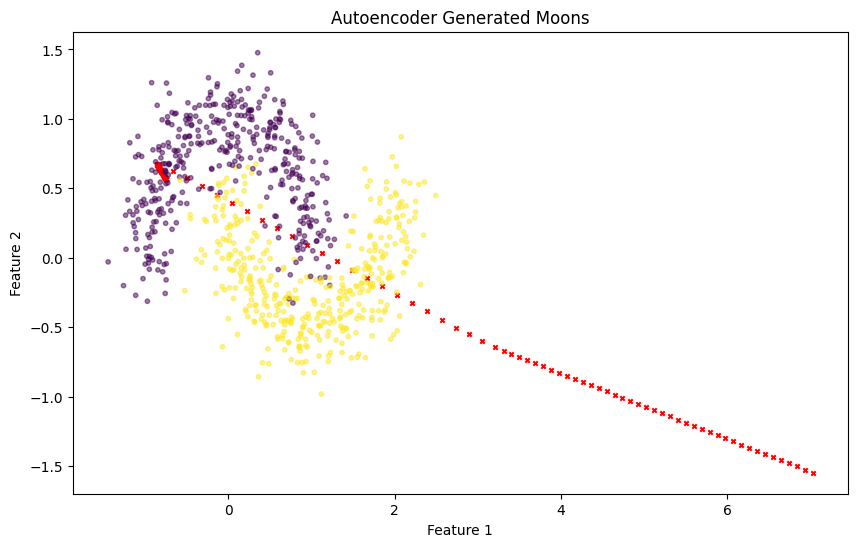

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [18]:
class MoonConditionalAutoencoder(nn.Module):
    def __init__(self):
        super(MoonConditionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def forward(self, x, y):
        latent = self.encoder(x)
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst
    
    def generate(self, latent, y):
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst

In [19]:
model = MoonConditionalAutoencoder()
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor, y_train_tensor.to(torch.long))
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = model(X_test_tensor, y_test_tensor.to(torch.long))
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 0.6692, Test Loss: 0.6254
Epoch [2], Loss: 0.6401, Test Loss: 0.5985
Epoch [3], Loss: 0.6144, Test Loss: 0.5761
Epoch [4], Loss: 0.5931, Test Loss: 0.5569
Epoch [5], Loss: 0.5750, Test Loss: 0.5393
Epoch [6], Loss: 0.5583, Test Loss: 0.5229
Epoch [7], Loss: 0.5429, Test Loss: 0.5076
Epoch [8], Loss: 0.5285, Test Loss: 0.4935
Epoch [9], Loss: 0.5150, Test Loss: 0.4805
Epoch [10], Loss: 0.5024, Test Loss: 0.4682
Epoch [11], Loss: 0.4904, Test Loss: 0.4563
Epoch [12], Loss: 0.4784, Test Loss: 0.4445
Epoch [13], Loss: 0.4662, Test Loss: 0.4335
Epoch [14], Loss: 0.4543, Test Loss: 0.4243
Epoch [15], Loss: 0.4434, Test Loss: 0.4146
Epoch [16], Loss: 0.4324, Test Loss: 0.4037
Epoch [17], Loss: 0.4201, Test Loss: 0.3911
Epoch [18], Loss: 0.4064, Test Loss: 0.3750
Epoch [19], Loss: 0.3891, Test Loss: 0.3562
Epoch [20], Loss: 0.3689, Test Loss: 0.3355
Epoch [21], Loss: 0.3464, Test Loss: 0.3136
Epoch [22], Loss: 0.3228, Test Loss: 0.2914
Epoch [23], Loss: 0.2986, Test Loss: 0.26

In [20]:
gen_input = torch.randn(200, 1) # torch.arange(-10, 10, 0.1).view(-1, 1) # torch.randn(200, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = model.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

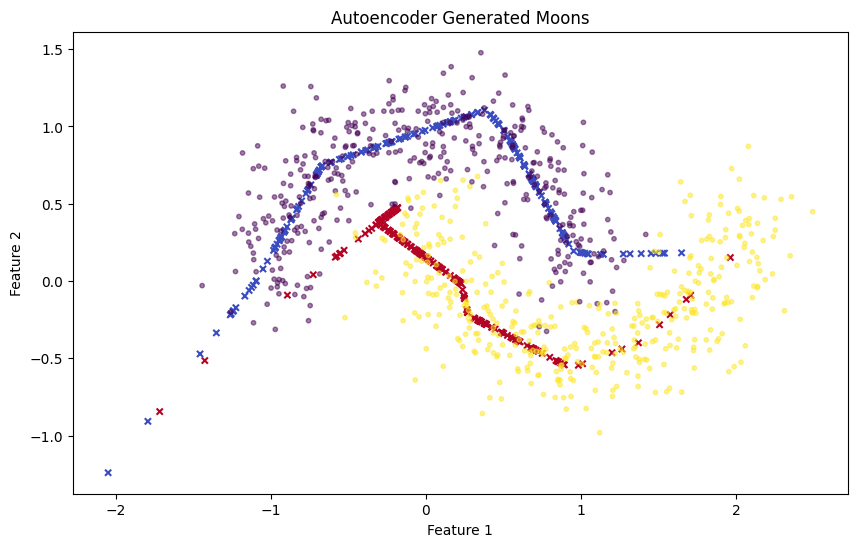

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=20, marker="x", cmap='coolwarm', c=y_gen)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Variational autoencoder (VAE)


In [22]:
class MoonVAE(nn.Module):
    def __init__(self):
        super(MoonVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z):
        x_reconst = self.decoder(z)
        return x_reconst

In [23]:
vae = MoonVAE()
vae.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae(X_train_tensor)
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae(X_test_tensor)
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 1.1025, Test Reconstruction Loss: 1.0629, Test KL Loss: 16.5114
Epoch [2], Loss: 1.0579, Test Reconstruction Loss: 1.0126, Test KL Loss: 13.7809
Epoch [3], Loss: 1.0123, Test Reconstruction Loss: 0.9870, Test KL Loss: 11.2602
Epoch [4], Loss: 0.9891, Test Reconstruction Loss: 0.9455, Test KL Loss: 8.9139
Epoch [5], Loss: 0.9538, Test Reconstruction Loss: 0.9177, Test KL Loss: 6.7088
Epoch [6], Loss: 0.9309, Test Reconstruction Loss: 0.8934, Test KL Loss: 4.6485
Epoch [7], Loss: 0.9022, Test Reconstruction Loss: 0.8736, Test KL Loss: 2.8738
Epoch [8], Loss: 0.8768, Test Reconstruction Loss: 0.8344, Test KL Loss: 1.4950
Epoch [9], Loss: 0.8426, Test Reconstruction Loss: 0.8112, Test KL Loss: 0.6137
Epoch [10], Loss: 0.8283, Test Reconstruction Loss: 0.7789, Test KL Loss: 0.3524
Epoch [11], Loss: 0.7963, Test Reconstruction Loss: 0.7491, Test KL Loss: 0.8824
Epoch [12], Loss: 0.7624, Test Reconstruction Loss: 0.7617, Test KL Loss: 2.4283
Epoch [13], Loss: 0.7431, Test Rec

In [24]:
gen_input = torch.randn(200, 1) # torch.arange(-10, 10, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = vae.generate(gen_input)
X_gen = X_gen.detach().numpy()

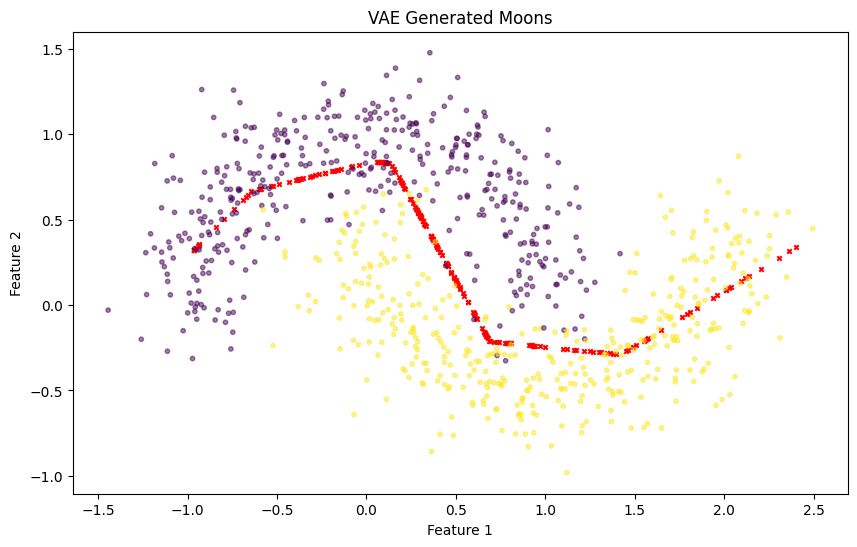

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [26]:
enc_out = vae.encoder(X_test_tensor)
mu = enc_out[:, 0].unsqueeze(1)
logvar = enc_out[:, 1].unsqueeze(1)

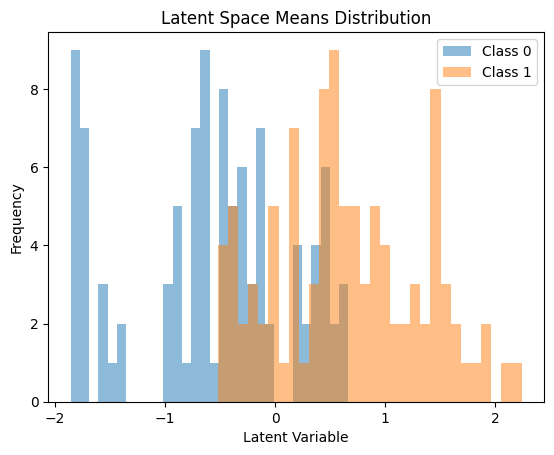

In [27]:
plt.hist(mu[y_test_tensor == 0].detach().numpy(), bins=30, alpha=0.5, label='Class 0')
plt.hist(mu[y_test_tensor == 1].detach().numpy(), bins=30, alpha=0.5, label='Class 1')
plt.title('Latent Space Means Distribution')
plt.xlabel('Latent Variable')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [28]:
class MoonVAEConditional(nn.Module):
    def __init__(self):
        super(MoonVAEConditional, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)

        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z, y):
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)
        x_reconst = self.decoder(z)
        return x_reconst

In [29]:
vae = MoonVAEConditional()
vae.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae(X_train_tensor, y_train_tensor.to(torch.long))
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae(X_test_tensor, y_test_tensor.to(torch.long))
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 0.9983, Test Reconstruction Loss: 0.9460, Test KL Loss: 8.0574
Epoch [2], Loss: 0.9517, Test Reconstruction Loss: 0.8998, Test KL Loss: 7.1524
Epoch [3], Loss: 0.9068, Test Reconstruction Loss: 0.8574, Test KL Loss: 6.4959
Epoch [4], Loss: 0.8671, Test Reconstruction Loss: 0.8227, Test KL Loss: 6.0226
Epoch [5], Loss: 0.8311, Test Reconstruction Loss: 0.7837, Test KL Loss: 5.6886
Epoch [6], Loss: 0.7962, Test Reconstruction Loss: 0.7499, Test KL Loss: 5.4952
Epoch [7], Loss: 0.7623, Test Reconstruction Loss: 0.7181, Test KL Loss: 5.4188
Epoch [8], Loss: 0.7332, Test Reconstruction Loss: 0.6899, Test KL Loss: 5.3890
Epoch [9], Loss: 0.7047, Test Reconstruction Loss: 0.6600, Test KL Loss: 5.3408
Epoch [10], Loss: 0.6781, Test Reconstruction Loss: 0.6350, Test KL Loss: 5.2089
Epoch [11], Loss: 0.6531, Test Reconstruction Loss: 0.6082, Test KL Loss: 4.9775
Epoch [12], Loss: 0.6287, Test Reconstruction Loss: 0.5855, Test KL Loss: 4.6294
Epoch [13], Loss: 0.6079, Test Recons

In [30]:
gen_input = torch.randn(200, 1) # torch.arange(-20, 20, 0.1).view(-1, 1) # torch.randn(200, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = vae.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

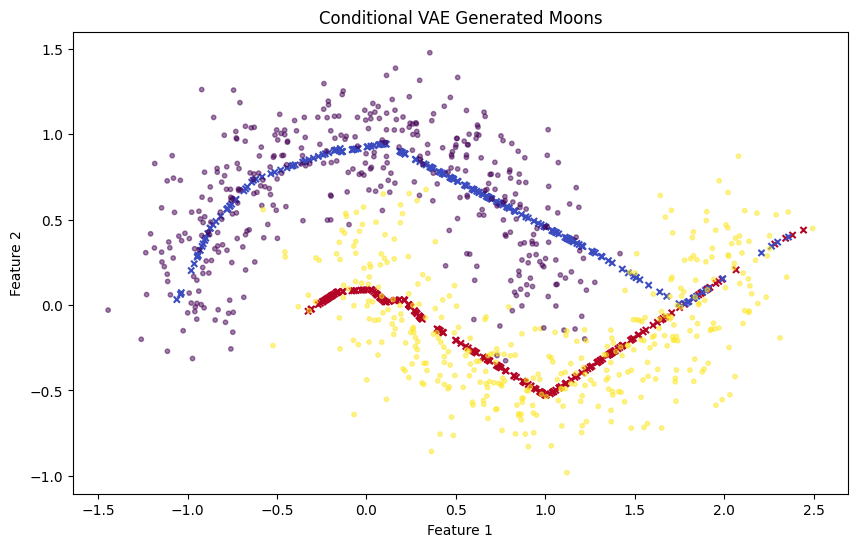

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=20, marker="x", c=y_gen, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Conditional VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Diffusion

![](./assets/diffusion.png)

Diffusion can be formalized as a fixed Markov chain with T steps. Each step depends only on the previous one, allowing us to derive a closed-form formula to obtain the corrupted image at any desired timestep, bypassing the need for iterative computation.

Schedulers:

![](./assets/schedulers.png)



In [56]:
class MoonsUNet(nn.Module):
    def __init__(self, num_timesteps=100, time_emb_dim=2):
        super(MoonsUNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(2 + time_emb_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.encoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8 + time_emb_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
        )
        self.bottleneck = nn.Sequential(
            nn.ReLU(),
            nn.Linear(4 + time_emb_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 4),
        )
        self.decoder1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.decoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        self.num_timesteps = num_timesteps
        self.time_embedding = nn.Embedding(num_timesteps, time_emb_dim)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)[:, 0]
        x = torch.cat((x, t_emb), dim=1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(torch.cat((enc1, t_emb), dim=1))
        bottleneck = self.bottleneck(torch.cat((enc2, t_emb), dim=1))
        dec1 = self.decoder1(torch.cat((bottleneck, enc2), dim=1))
        dec2 = self.decoder2(torch.cat((dec1, enc1), dim=1))
        return dec2

In [57]:
num_epochs = 1000
num_timesteps = 100

unet = MoonsUNet(num_timesteps=num_timesteps, time_emb_dim=2)
unet.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)

In [ ]:
def linear_schedule(t, timesteps):
    return t / timesteps

def cosine_schedule(t, timesteps, s=0.008):
    alpha_hat = np.cos(np.pi/2*(t / timesteps + s)/(1 + s))**2
    alpha_hat_prev = np.cos(np.pi/2*((t-1) / timesteps + s)/(1 + s))**2
    beta = 1 - alpha_hat/alpha_hat_prev
    return 0.999 if beta > 0.999 else beta

def apply_diffusion(X, t, schedule):
    alpha = 1 - schedule(t, num_timesteps)
    noise = np.random.normal(scale=1, size=X.shape)
    return alpha * X + (1 - alpha) * noise, noise

def update_plot(*args):
    with output:
        output.clear_output(wait=True)
        
        schedule = linear_schedule if dropdown_schedule.value == "Linear" else cosine_schedule
        X_noisy, _ = apply_diffusion(X_train, slider_timesteps.value, schedule)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_train, s=10, cmap='viridis')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title('Moons Dataset with Diffusion')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.5, 1.5)
        
        display(fig)
        plt.close(fig)

slider_timesteps = widgets.IntSlider(min=1, max=num_timesteps, step=1, value=1, description="Timesteps")
dropdown_schedule = widgets.Dropdown(options=["Linear", "Cosine"], value="Linear", description="Schedule")
output = widgets.Output()

slider_timesteps.observe(update_plot, names='value')
dropdown_schedule.observe(update_plot, names='value')

display(slider_timesteps, dropdown_schedule, output)
update_plot()

IntSlider(value=1, description='Timesteps', min=1)

Dropdown(description='Schedule', options=('Linear', 'Cosine'), value='Linear')

Output()

In [ ]:
chosen_schedule = linear_schedule

for epoch in range(num_epochs):
    timesteps = torch.randint(0, num_timesteps, (X_train_tensor.size(0), 1))

    optimizer.zero_grad()
    noisy_X, noise = apply_diffusion(X_train_tensor, timesteps, chosen_schedule)
    outputs = unet(noisy_X, timesteps)
    loss = criterion(outputs, noise)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        noisy_X, noise = apply_diffusion(X_test_tensor, timesteps, chosen_schedule)
        outputs = unet(noisy_X, timesteps)
        test_loss = criterion(outputs, noise)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


torch.Size([800, 2]) torch.Size([800, 1])
Alpha: torch.Size([800, 1])


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

## NLP

![](./assets/chatgpt.jpg)

autoregression, tokens, BPE

## Evaluating generative models

### Frechet distance

Lower (better) if generated and real distributions are similar.

$d^2 = |\mu_X - \mu_Y|^2 + \text{tr}(\Sigma_X + \Sigma_Y - 2(\Sigma_X\Sigma_Y)^{0.5})$

![](./assets/FID.png)

FAD - Frechet Audio Distance

### Inception score

Higher (better) if:
- Images vary;
- Images correspond to model classes.

![](./assets/inception_score.webp)

$\text{IS} = e^{\mathbb{E}_{\mathbf{x}}\text{D}_{\text{KL}}(p(y|\mathbf{x})\|p(y)))}$

$\text{D}_{\text{KL}}(P\|Q) = -\sum_{x\in X}P(x)\log{\frac{Q(x)}{P(x)}}$

![](./assets/kl.webp)

### CLIP score

![](./assets/clip.svg)